Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
discriminator_3 (Discriminat (None, 2, 2, 1)           2764481   
Total params: 2,764,481
Trainable params: 2,764,481
Non-trainable params: 0
_________________________________________________________________


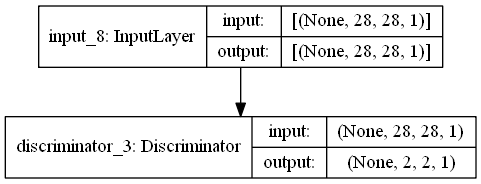

In [4]:
import tensorflow as tf 
from tensorflow.keras.layers import Input, Conv2D, Flatten
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
from IPython import display

class InstanceNorm_kong(tf.keras.layers.Layer):
    def __init__(self):
        super(InstanceNorm_kong, self).__init__()

    def build(self, input_shape):
        depth = input_shape[-1]
        self.scale  = self.add_weight("scale", shape = [depth], initializer=tf.random_normal_initializer(mean=1.0, stddev=0.02), dtype=tf.float32)
        self.offset = self.add_weight("offset", shape = [depth], initializer=tf.constant_initializer(0.0), dtype=tf.float32 )

    def call(self, input):
        mean, variance = tf.nn.moments(input, axes=[1,2], keepdims=True)
        epsilon = tf.constant(1e-5,dtype=tf.float32)
        inv = tf.math.rsqrt(variance + epsilon)
        normalized = (input-mean)*inv
        
        return self.scale*normalized + self.offset
        # return tf.matmul(input, self.kernel)


class Discriminator(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(Discriminator, self).__init__(**kwargs)
        self.conv_1 = Conv2D(64  ,   kernel_size=4, strides=2, padding="same")
        self.conv_2 = Conv2D(64*2,   kernel_size=4, strides=2, padding="same")
        self.conv_3 = Conv2D(64*4,   kernel_size=4, strides=2, padding="same")
        self.conv_4 = Conv2D(64*8,   kernel_size=4, strides=2, padding="same")
        self.conv_map = Conv2D(1   ,   kernel_size=4, strides=1, padding="same")

        self.in_c2   = InstanceNorm_kong()
        self.in_c3   = InstanceNorm_kong()
        self.in_c4   = InstanceNorm_kong()
    
    def call(self, input_tensor):
        x = self.conv_1(input_tensor)
        x = tf.nn.leaky_relu(x, alpha=0.2)

        x = self.conv_2(x)
        x = self.in_c2(x)
        x = tf.nn.leaky_relu(x, alpha=0.2)

        x = self.conv_3(x)
        x = self.in_c3(x)
        x = tf.nn.leaky_relu(x, alpha=0.2)

        x = self.conv_4(x)
        x = self.in_c4(x)
        x = tf.nn.leaky_relu(x, alpha=0.2)

        return self.conv_map(x)

encoder_in = Input(shape = (28,28,1))
x = Conv2D(3, kernel_size=3, strides=1, padding="same")(encoder_in)
encoder = Model(encoder_in, x)
# encoder.summary()

d_in = Input(shape = (28,28,1))
d = Discriminator()(d_in)
discriminator = Model(d_in,d)
discriminator.summary()
tf.keras.utils.plot_model(discriminator,show_shapes = True)